<a href="https://colab.research.google.com/github/Patric/fkd-gs/blob/master/notebooks/FakeNewsDetectionGraphSolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake news detection using graph solutions

This notebook is a walkthrough feature selection process and machine learning effects of Fake news detection using graph solution Master's Thesis.

# Code formatting
Use !black command once to format the code, then use F5 and then save. Uncomment when needed

In [ ]:
# ! pip install black[jupyter]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !black /content/drive/MyDrive/ColabNotebooks/FakeNewsDetectionGraphSolutions.ipynb

All done! ✨ 🍰 ✨
1 file left unchanged.


# Dataset loading

## Mount google drive with processed features and define dataset paths

In [40]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libs for operating on datasets

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Set datasets paths variables

Warning!!! These are Colab based paths. As for now data should be saved to your google drive from https://drive.google.com/drive/folders/1HOEIyiiFBALoqrHN5Jh8RczkvMIgUVyH?usp=sharing
 Paths should be adjusted accordingly

In [42]:
# variable should be adjusted according to your google drive TODO: figure out how to bond datasets more simply
features_directory_path = "/content/drive/MyDrive/FakeNewsDetectonColabNotebooks/resources/features"

politifact_more_than_1_relation_path = (
    f"{features_directory_path}/politifact_more_than_1_relation/"
)
politifact_all_path = f"{features_directory_path}/politifact_all/"
gossipcop_path = f"{features_directory_path}/gossipcop/"

e13_followers_path = f"{features_directory_path}/MIB/E13/"
fsf_followers_path = f"{features_directory_path}/MIB/FSF/"
int_followers_path = f"{features_directory_path}/MIB/INT/"
twt_followers_path = f"{features_directory_path}/MIB/TWT/"
tfp_followers_path = f"{features_directory_path}/MIB/TFP/"

In [43]:
features_files_names = [
    "eigenvector_to_label.csv",
    "harmonic_closeness_to_label.csv",
    "hits_to_label.csv",
    "betweenness_to_label.csv",
    "closeness_to_label.csv",
    "page_rank_to_label.csv",
    "article_rank_to_label.csv",
    "degree_to_label.csv",
]

## Define util functions

In [44]:
def get_data_frame(*paths):
    paths = list(sum(paths, []))
    dfs = list(map(lambda path: pd.read_csv(path), paths))
    df = pd.concat(dfs, join="outer", axis=1)
    df = df.loc[:, ~df.columns.duplicated()].copy()
    return df


def get_feature_full_path(data_set_path, feature_data):
    return f"{data_set_path}{feature_data}"


def get_features_paths(data_set_path, features_files):
    return list(
        map(
            lambda feature_file: get_feature_full_path(data_set_path, feature_file),
            features_files,
        )
    )

## Convert datasets to Pandas DataFrames

In [45]:
dfs_mib_combined = list(map(lambda dataset_path: get_data_frame(get_features_paths(dataset_path, features_files_names)),
[e13_followers_path, fsf_followers_path, int_followers_path, twt_followers_path, tfp_followers_path]))

In [46]:
df_politifact = get_data_frame(get_features_paths(politifact_all_path, features_files_names))
df_politifact_more_than_1_relation = get_data_frame(get_features_paths(politifact_more_than_1_relation_path, features_files_names))

df_gossipcop = get_data_frame(get_features_paths(gossipcop_path, features_files_names))

df_fake_news_net_skeleton_combined = pd.concat([df_politifact, df_gossipcop])

# Feature selection


## Import libs for feature selection

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import r_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import seaborn as sns

## Define feature selection functions

In [71]:
def select_features_chi2(X_train, y_train, X_test, should_plot_output=False):
  # configure to select all features
  fs = SelectKBest(score_func=chi2, k='all')
  # learn relationship from training data
  fs.fit(X_train, y_train)
  # transform train input data
  X_train_fs = fs.transform(X_train)
  # transform test input data
  X_test_fs = fs.transform(X_test)
  for i in range(len(fs.scores_)):
      print('Feature %s: score: %f p_value: %f' % (fs.feature_names_in_[i], fs.scores_[i], fs.pvalues_[i]))

  # plot p_value
  if should_plot_output:
    plt.bar([i for i in range(len(fs.pvalues_))], fs.pvalues_)
    plt.show()

  return X_train_fs, X_test_fs, fs

In [72]:
def select_features_f(X_train, y_train, X_test, should_plot_output=False):
  # configure to select all features
  fs = SelectKBest(score_func=f_classif, k='all')
  # learn relationship from training data
  fs.fit(X_train, y_train)
  # transform train input data
  X_train_fs = fs.transform(X_train)
  # transform test input data
  X_test_fs = fs.transform(X_test)
  for i in range(len(fs.scores_)):
    print('Feature %s: score: %f p_value: %f' % (fs.feature_names_in_[i], fs.scores_[i], fs.pvalues_[i]))
  
  # plot p_value
  if should_plot_output:
    plt.bar([i for i in range(len(fs.pvalues_))], fs.pvalues_)
    plt.show()
    
  return X_train_fs, X_test_fs, fs

In [73]:
def select_features_mutual_info(X_train, y_train, X_test, should_plot_output=False):
  # configure to select all features
  fs = SelectKBest(score_func=mutual_info_classif, k='all')
  # learn relationship from training data
  fs.fit(X_train, y_train)
  # transform train input data
  X_train_fs = fs.transform(X_train)
  # transform test input data
  X_test_fs = fs.transform(X_test)
  for i in range(len(fs.scores_)):
    print('Feature %s: score: %f' % (fs.feature_names_in_[i], fs.scores_[i]))
  
  # plot p_value
  if should_plot_output:
    plt.bar([i for i in range(len(fs.pvalues_))], fs.pvalues_)
    plt.show()
    
  return X_train_fs, X_test_fs, fs

In [82]:
def select_features_r(X_train, y_train, X_test, should_plot_output=False):
  # configure to select all features
  fs = SelectKBest(score_func=r_regression, k='all')
  # learn relationship from training data
  fs.fit(X_train, y_train)
  # transform train input data
  X_train_fs = fs.transform(X_train)
  # transform test input data
  X_test_fs = fs.transform(X_test)
  for i in range(len(fs.scores_)):
    print('Feature %s: score: %f' % (fs.feature_names_in_[i], fs.scores_[i]))
  
  # plot p_value
  if should_plot_output:
    plt.bar([i for i in range(len(fs.pvalues_))], fs.pvalues_)
    plt.show()
  
  # TODO: checkout if X_train_fs, X_test_fs needed
  return X_train_fs, X_test_fs, fs

In [80]:
def tree_classifier(X_train, y_train, X_test):
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X_train, y_train)
    print(clf.feature_importances_)

In [76]:
def plot_pearson_corr_matrix(data_frame):
  with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3):
    pd.options.display.float_format = '{:.3f}'.format
    print(data_frame.corr(method='pearson'))

In [77]:
# split into dependend and independent variables
def split_into_X_y(data_frame, dependent_variables_list, independend_variable):
  X = data_frame[dependent_variables_list]
  y = data_frame[independend_variable]

  return X, y

In [86]:
def test_linear_regression_model(X_train, y_train):
  linreg=LinearRegression()
  linreg.fit(X_train,y_train)
  y_pred=linreg.predict(X_test)
  Accuracy=r2_score(y_test,y_pred)*100
  print(" Accuracy of the model is %.2f" %Accuracy)
  plt.scatter(y_test,y_pred)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.show()
  sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')
  plt.show()

## Test feature dependency

In [ ]:
features_included = [
        'eigenvector_score',
        'harmonic_closeness_centrality',
        'hits_hub',
        'hits_auth',
        'betweenness_score',
        'closeness_score',
        'page_rank_score',
        'outDegree',
        'inDegree',
        'degree'
        ]
label_column_name = 'user.label'
X, y = split_into_X_y(df_fake_news_net_skeleton_combined, features_included, label_column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
print('Mutual Info')
select_features_mutual_info(X_train, y_train, X_test)
print('Mutual f classif (F-test)')
select_features_f(X_train, y_train, X_test)
print('Chi2')
select_features_chi2(X_train, y_train, X_test)
print('Pearson')
select_features_r(X_train, y_train, X_test)
print('Tree classifier')
tree_classifier(X_train, y_train, X_test)

Linear regression of features: ['eigenvector_score', 'harmonic_closeness_centrality', 'hits_hub', 'hits_auth', 'betweenness_score', 'closeness_score', 'page_rank_score', 'outDegree', 'inDegree', 'degree']
 Accuracy of the model is 5.77


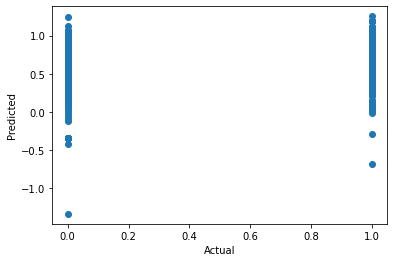

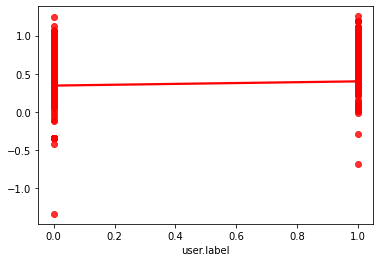

In [87]:
print(f'Linear regression of features: {features_included}')
test_linear_regression_model(X_train, y_train)

# Classifiers testing

## Import libs for classifiers testing

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold

## Test classifiers functions

In [ ]:
def test_classfiers(df):
        classifiers = [
        # KNeighborsClassifier(3),
        # SVC(kernel="rbf", C=0.025, probability=True),
        # NuSVC(probability=True),
        DecisionTreeClassifier(),
        RandomForestClassifier(n_estimators=1500),
        # AdaBoostClassifier(),
        GradientBoostingClassifier(),
        GaussianNB(),
        # LinearDiscriminantAnalysis(),
        # QuadraticDiscriminantAnalysis()
        ]

        X = df[[#'eigenvector_score', 
               # 'harmonic_closeness_centrality', 
            #    'hits_hub',
           #     'hits_auth',
                'betweenness_score',
                'closeness_score',
            #    'page_rank_score',
            #    'outDegree',
            #    'inDegree',
            #    'degree'
            ]]

        y = df['user.label']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        log_cols = ["Classifier", "Accuracy", "Log Loss"]
        log = pd.DataFrame(columns=log_cols)

        for clf in classifiers:
                clf.fit(X_train, y_train)
                name = clf.__class__.__name__

                print("=" * 30)
                print(name)

                print('****Results****')
                train_predictions = clf.predict(X_test)
                acc = accuracy_score(y_test, train_predictions)
                print("Accuracy: {:.4%}".format(acc))

                train_predictions = clf.predict_proba(X_test)
                ll = log_loss(y_test, train_predictions)
                print("Log Loss: {}".format(ll))

                log_entry = pd.DataFrame([[name, acc * 100, ll]], columns=log_cols)
                log = log.append(log_entry)


        print("=" * 30)

# Markup helper TODO: delete


Markdown | Preview
--- | ---
`**bold text**` | **bold text**
`*italicized text*` or `_italicized text_` | *italicized text*
`` `Monospace` `` | `Monospace`
`~~strikethrough~~` | ~~strikethrough~~
`[A link](https://www.google.com)` | [A link](https://www.google.com)
`![An image](https://www.google.com/images/rss.png)` | ![An image](https://www.google.com/images/rss.png)


---
Headings are rendered as titles.

```markdown
# Section 1
# Section 2
## Sub-section under Section 2
### Sub-section under the sub-section under Section 2
# Section 3
```

# Section 1
# Section 2
## Sub-section under Section 2
### Sub-section under the sub-section under Section 2
# Section 3

The table of contents, available on the left side of Colab, is populated using at most one section title from each text cell.

---

```markdown
>One level of indentation
```

>One level of indentation


```markdown
>>Two levels of indentation
```

>>Two levels of indentation

---

Code blocks

````
```python
print("a")
```
````

```python
print("a")
```

---

Ordered lists:
```markdown
1. One
1. Two
1. Three
```
1. One
1. Two
1. Three

---

Unordered lists:
```markdown
* One
* Two
* Three
```
* One
* Two
* Three

---

Equations:

```markdown
$y=x^2$

$e^{i\pi} + 1 = 0$

$e^x=\sum_{i=0}^\infty \frac{1}{i!}x^i$

$\frac{n!}{k!(n-k)!} = {n \choose k}$

$A_{m,n} =
 \begin{pmatrix}
  a_{1,1} & a_{1,2} & \cdots & a_{1,n} \\
  a_{2,1} & a_{2,2} & \cdots & a_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  a_{m,1} & a_{m,2} & \cdots & a_{m,n}
 \end{pmatrix}$
```

$y=x^2$

$e^{i\pi} + 1 = 0$

$e^x=\sum_{i=0}^\infty \frac{1}{i!}x^i$

$\frac{n!}{k!(n-k)!} = {n \choose k}$

$A_{m,n} =
 \begin{pmatrix}
  a_{1,1} & a_{1,2} & \cdots & a_{1,n} \\
  a_{2,1} & a_{2,2} & \cdots & a_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  a_{m,1} & a_{m,2} & \cdots & a_{m,n}
 \end{pmatrix}$


 ---

Tables:
```markdown
First column name  | Second column name 
-------------------|------------------
Row 1, Col 1       | Row 1, Col 2 
Row 2, Col 1       | Row 2, Col 2 

```

First column name  | Second column name 
-------------------|------------------
Row 1, Col 1       | Row 1, Col 2 
Row 2, Col 1       | Row 2, Col 2 

---

Horizontal rules:
```markdown
---
```

---




## Differences between Colab Markdown and other Markdown dialects

Colab uses [marked.js](https://github.com/chjj/marked) and so is similar but not quite identical to the Markdown used by Jupyter and Github.

Colab supports (MathJax) $\LaTeX$ equations like Jupyter, but does not allow HTML tags in the Markdown. Colab does not support some GitHub additions like emojis and to-do checkboxes.

If HTML must be included in a Colab notebook, see the [%%html magic](/notebooks/basic_features_overview.ipynb#scrollTo=qM4myQGfQboQ).

## Useful references

* [Github Markdown basics](https://help.github.com/articles/markdown-basics/)
* [Github flavored Markdown](https://help.github.com/articles/github-flavored-markdown/)
* [Original Markdown spec: Syntax](http://daringfireball.net/projects/markdown/syntax)
* [Original Markdown spec: Basics](http://daringfireball.net/projects/markdown/basics)
* [marked.js library used by Colab](https://github.com/chjj/marked)
* [LaTex mathematics for equations](https://en.wikibooks.org/wiki/LaTeX/Mathematics)